# 🤖 Machine Learning Não Supervisionado
## Segmentação de Clientes - K-Means Clustering

**Objetivo:** Identificar grupos de clientes com comportamentos similares para estratégias de marketing personalizadas.

---

## 1. Setup e Importações

In [1]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Configurações
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Bibliotecas importadas!")

✅ Bibliotecas importadas!


## 2. Carregar Dados

In [2]:
# Conectar ao banco
conn = sqlite3.connect('../vendas_carros_esportivos.db')

# Query: Perfil completo dos clientes
query = """
SELECT 
    c.cliente_id,
    c.nome,
    c.genero,
    CAST((julianday('now') - julianday(c.data_nascimento)) / 365.25 AS INTEGER) as idade,
    c.renda_anual,
    c.profissao,
    c.estado,
    COUNT(DISTINCT v.venda_id) as total_compras,
    COALESCE(SUM(v.valor_venda), 0) as valor_total_gasto,
    COALESCE(AVG(v.valor_venda), 0) as ticket_medio,
    COALESCE(MAX(v.data_venda), c.data_cadastro) as ultima_compra,
    COUNT(DISTINCT td.test_drive_id) as total_test_drives,
    COALESCE(AVG(td.avaliacao), 0) as avaliacao_media_test_drive,
    COUNT(DISTINCT s.servico_id) as total_servicos
FROM clientes c
LEFT JOIN vendas v ON c.cliente_id = v.cliente_id AND v.status_venda = 'Concluída'
LEFT JOIN test_drives td ON c.cliente_id = td.cliente_id
LEFT JOIN servicos_pos_venda s ON v.venda_id = s.venda_id
GROUP BY c.cliente_id
"""

df = pd.read_sql(query, conn)
conn.close()

print(f"✅ Dados carregados: {len(df):,} clientes")
print(f"📊 Shape: {df.shape}")
df.head()

✅ Dados carregados: 1,977 clientes
📊 Shape: (1977, 14)


,cliente_id,nome,genero,idade,renda_anual,profissao,estado,total_compras,valor_total_gasto,ticket_medio,ultima_compra,total_test_drives,avaliacao_media_test_drive,total_servicos
0,1,Brenda Alves,Masculino,47,442980.71,Dentista,SP,1,1991354.85,663784.95,2023-10-01,3,4.333333,0
1,2,Thiago Pereira,Masculino,38,2024137.64,Arquiteto,MG,0,0.00,0.00,2023-08-18,2,3.500000,0
2,3,Dr. Eduardo Cunha,Masculino,41,821493.12,Promotor,SP,0,0.00,0.00,2024-06-05,2,2.500000,0
3,4,Yuri da Rocha,Masculino,43,1167394.82,Desenvolvedor de Software,GO,0,0.00,0.00,2024-07-06,0,0.000000,0
4,5,Léo Fogaça,Outro,37,553565.77,Advogado,SP,0,0.00,0.00,2024-10-27,1,5.000000,0


## 3. Análise Exploratória Inicial

In [8]:
# Estatísticas descritivas
print("📊 Estatísticas dos Clientes:")
df[['idade', 'renda_anual', 'total_compras', 'valor_total_gasto', 'ticket_medio']].describe()

📊 Estatísticas dos Clientes:


,idade,renda_anual,total_compras,valor_total_gasto,ticket_medio
count,1977.000000,1.977000e+03,1977.000000,1.977000e+03,1.977000e+03
mean,42.134041,7.923212e+05,0.704603,1.683087e+06,3.997779e+05
std,9.070559,4.462851e+05,0.930665,3.529438e+06,4.681438e+05
min,25.000000,8.500000e+04,0.000000,0.000000e+00,0.000000e+00
25%,35.000000,4.253561e+05,0.000000,0.000000e+00,0.000000e+00
50%,41.000000,6.912055e+05,0.000000,0.000000e+00,0.000000e+00
75%,49.000000,1.084899e+06,1.000000,1.829677e+06,7.934704e+05
max,67.000000,2.187824e+06,6.000000,3.810153e+07,2.314598e+06


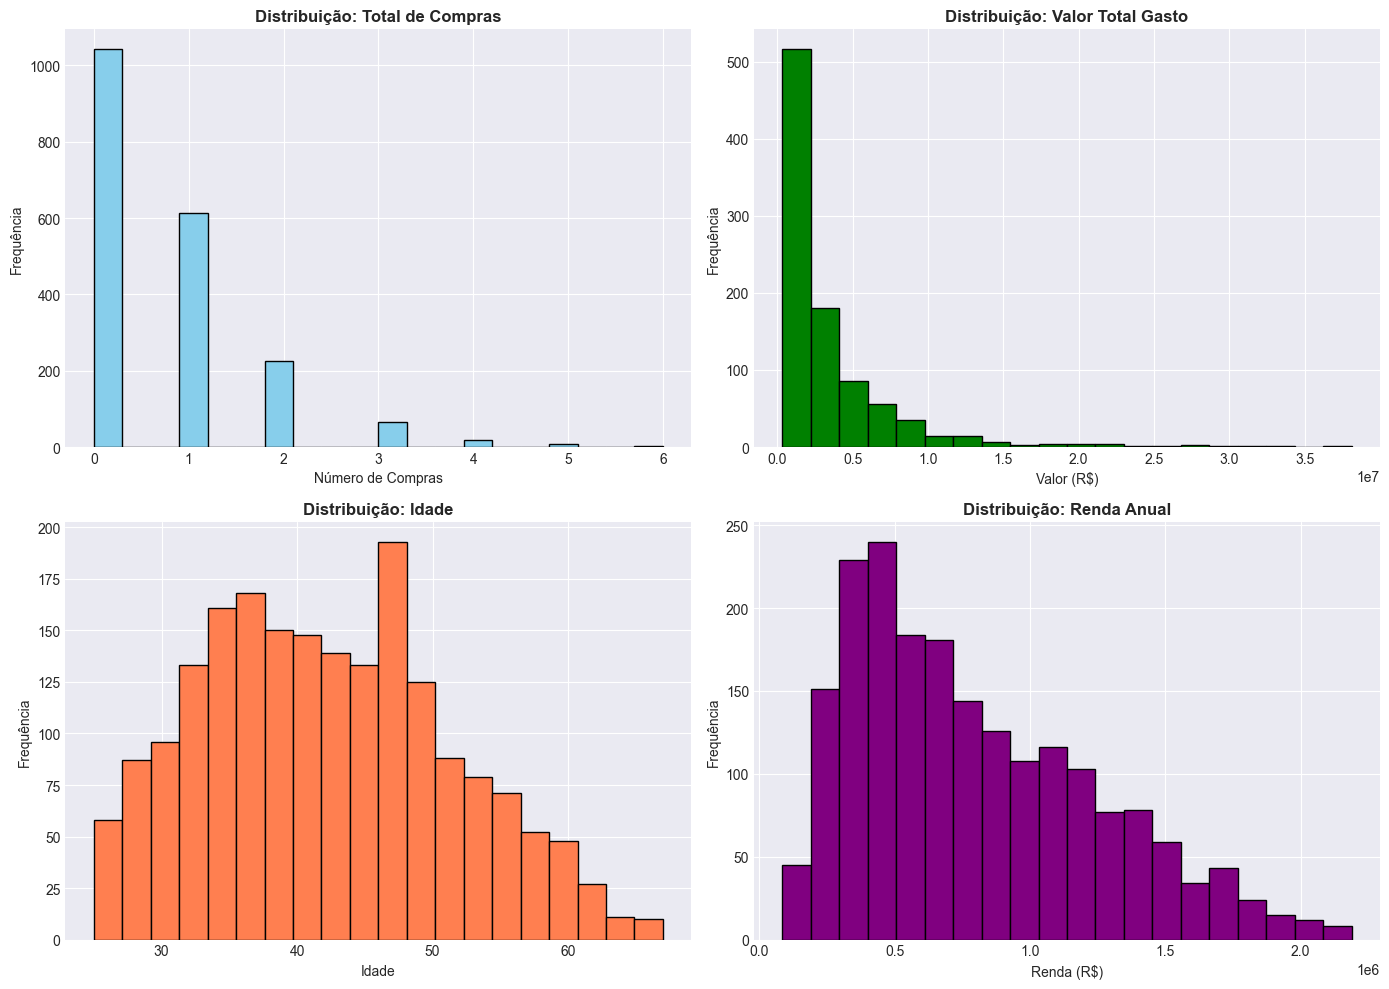

In [9]:
# Distribuição de compras
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total de compras
axes[0, 0].hist(df['total_compras'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribuição: Total de Compras', fontweight='bold')
axes[0, 0].set_xlabel('Número de Compras')
axes[0, 0].set_ylabel('Frequência')

# Valor total gasto
axes[0, 1].hist(df[df['valor_total_gasto'] > 0]['valor_total_gasto'], bins=20, color='green', edgecolor='black')
axes[0, 1].set_title('Distribuição: Valor Total Gasto', fontweight='bold')
axes[0, 1].set_xlabel('Valor (R$)')
axes[0, 1].set_ylabel('Frequência')

# Idade
axes[1, 0].hist(df['idade'], bins=20, color='coral', edgecolor='black')
axes[1, 0].set_title('Distribuição: Idade', fontweight='bold')
axes[1, 0].set_xlabel('Idade')
axes[1, 0].set_ylabel('Frequência')

# Renda
axes[1, 1].hist(df['renda_anual'], bins=20, color='purple', edgecolor='black')
axes[1, 1].set_title('Distribuição: Renda Anual', fontweight='bold')
axes[1, 1].set_xlabel('Renda (R$)')
axes[1, 1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

## 4. Preparação dos Dados para Clustering

In [10]:
# Selecionar features para clustering
features = ['idade', 'renda_anual', 'total_compras', 'valor_total_gasto', 
           'ticket_medio', 'total_test_drives', 'avaliacao_media_test_drive']

# Criar dataset de features
X = df[features].copy()

# Tratar valores missing (substituir por 0)
X = X.fillna(0)

print("✅ Features selecionadas:")
print(X.columns.tolist())
print(f"\n📊 Shape: {X.shape}")
print(f"\n🔍 Missing values: {X.isnull().sum().sum()}")

✅ Features selecionadas:
['idade', 'renda_anual', 'total_compras', 'valor_total_gasto', 'ticket_medio', 'total_test_drives', 'avaliacao_media_test_drive']

📊 Shape: (1977, 7)

🔍 Missing values: 0


In [11]:
# Normalizar dados (importante para K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Dados normalizados!")
print(f"📊 Shape: {X_scaled.shape}")
print(f"\n📈 Média: {X_scaled.mean():.2f}")
print(f"📊 Desvio padrão: {X_scaled.std():.2f}")

✅ Dados normalizados!
📊 Shape: (1977, 7)

📈 Média: 0.00
📊 Desvio padrão: 1.00


## 5. Determinar Número Ideal de Clusters

In [12]:
# Método do Cotovelo (Elbow Method)
inertias = []
silhouette_scores = []
K_range = range(2, 11)

print("🔍 Testando diferentes números de clusters...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"   K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")

print("\n✅ Análise concluída!")

🔍 Testando diferentes números de clusters...
   K=2: Inertia=9229.70, Silhouette=0.315
   K=3: Inertia=7477.83, Silhouette=0.274
   K=4: Inertia=6184.26, Silhouette=0.285
   K=5: Inertia=5386.31, Silhouette=0.279
   K=6: Inertia=4903.39, Silhouette=0.274
   K=7: Inertia=4476.89, Silhouette=0.267
   K=8: Inertia=4069.06, Silhouette=0.264
   K=9: Inertia=3709.29, Silhouette=0.277
   K=10: Inertia=3425.50, Silhouette=0.287

✅ Análise concluída!


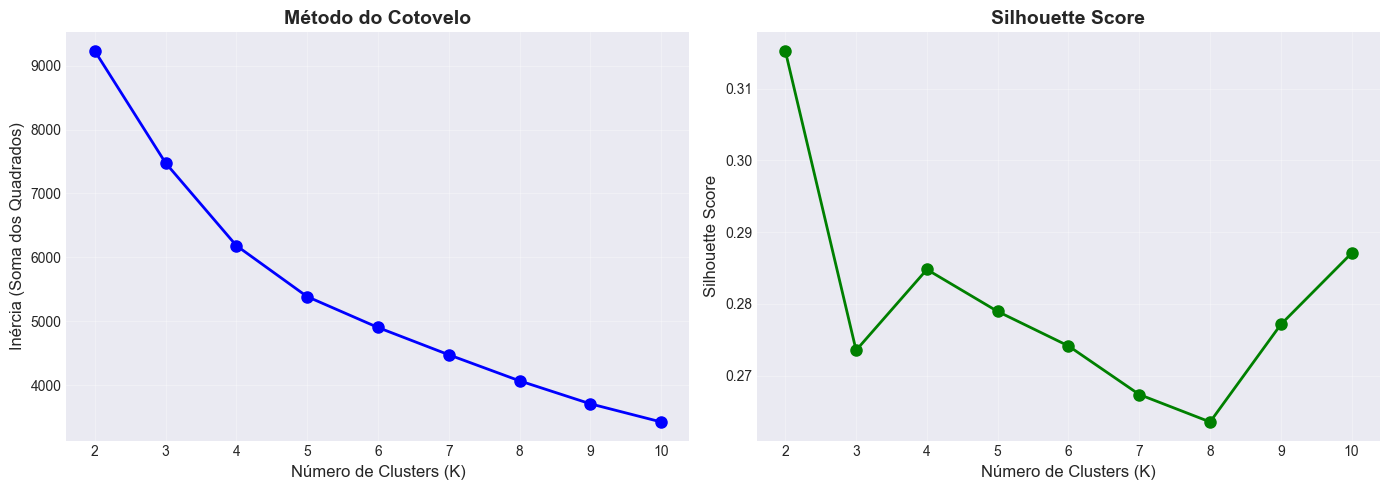


🎯 Número ideal de clusters (Silhouette): K=2


In [13]:
# Visualizar métodos de seleção
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Método do Cotovelo
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inércia (Soma dos Quadrados)', fontsize=12)
axes[0].set_title('Método do Cotovelo', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Melhor K baseado em Silhouette
best_k = K_range[np.argmax(silhouette_scores)]
print(f"\n🎯 Número ideal de clusters (Silhouette): K={best_k}")

## 6. Aplicar K-Means com K Ideal

In [14]:
# Escolher K (baseado na análise ou fixo)
K_FINAL = 4  # Ajuste conforme análise acima

print(f"🎯 Aplicando K-Means com K={K_FINAL}...")

# Treinar modelo final
kmeans_final = KMeans(n_clusters=K_FINAL, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# Adicionar clusters ao dataframe
df['cluster'] = clusters

# Métricas de avaliação
silhouette = silhouette_score(X_scaled, clusters)
davies_bouldin = davies_bouldin_score(X_scaled, clusters)

print(f"\n✅ Clustering concluído!")
print(f"📊 Silhouette Score: {silhouette:.3f} (quanto maior, melhor)")
print(f"📊 Davies-Bouldin Score: {davies_bouldin:.3f} (quanto menor, melhor)")

# Distribuição dos clusters
print(f"\n📊 Distribuição dos clientes nos clusters:")
print(df['cluster'].value_counts().sort_index())

🎯 Aplicando K-Means com K=4...

✅ Clustering concluído!
📊 Silhouette Score: 0.285 (quanto maior, melhor)
📊 Davies-Bouldin Score: 1.272 (quanto menor, melhor)

📊 Distribuição dos clientes nos clusters:
cluster
0    463
1    653
2    141
3    720
Name: count, dtype: int64


## 7. Análise dos Clusters (Perfil de Cada Grupo)

In [15]:
# Perfil de cada cluster
print("="*80)
print("👥 PERFIL DOS CLUSTERS")
print("="*80)

cluster_profiles = df.groupby('cluster')[features].mean()
cluster_sizes = df['cluster'].value_counts().sort_index()

for cluster_id in range(K_FINAL):
    print(f"\n🔵 CLUSTER {cluster_id} ({cluster_sizes[cluster_id]} clientes)")
    print("-" * 80)
    profile = cluster_profiles.loc[cluster_id]
    print(f"   Idade Média: {profile['idade']:.1f} anos")
    print(f"   Renda Média: R$ {profile['renda_anual']:,.2f}")
    print(f"   Compras Médias: {profile['total_compras']:.2f}")
    print(f"   Gasto Total Médio: R$ {profile['valor_total_gasto']:,.2f}")
    print(f"   Ticket Médio: R$ {profile['ticket_medio']:,.2f}")
    print(f"   Test Drives: {profile['total_test_drives']:.2f}")
    print(f"   Avaliação Média: {profile['avaliacao_media_test_drive']:.2f}/5")

print("\n" + "="*80)

👥 PERFIL DOS CLUSTERS

🔵 CLUSTER 0 (463 clientes)
--------------------------------------------------------------------------------
   Idade Média: 41.7 anos
   Renda Média: R$ 636,693.06
   Compras Médias: 0.14
   Gasto Total Médio: R$ 121,878.48
   Ticket Médio: R$ 101,590.08
   Test Drives: 0.06
   Avaliação Média: 0.06/5

🔵 CLUSTER 1 (653 clientes)
--------------------------------------------------------------------------------
   Idade Média: 43.7 anos
   Renda Média: R$ 963,596.57
   Compras Médias: 1.30
   Gasto Total Médio: R$ 2,409,438.45
   Ticket Médio: R$ 866,690.00
   Test Drives: 1.99
   Avaliação Média: 4.01/5

🔵 CLUSTER 2 (141 clientes)
--------------------------------------------------------------------------------
   Idade Média: 43.4 anos
   Renda Média: R$ 1,339,909.92
   Compras Médias: 2.84
   Gasto Total Médio: R$ 11,644,075.26
   Ticket Médio: R$ 984,690.07
   Test Drives: 3.72
   Avaliação Média: 4.23/5

🔵 CLUSTER 3 (720 clientes)
-------------------------------

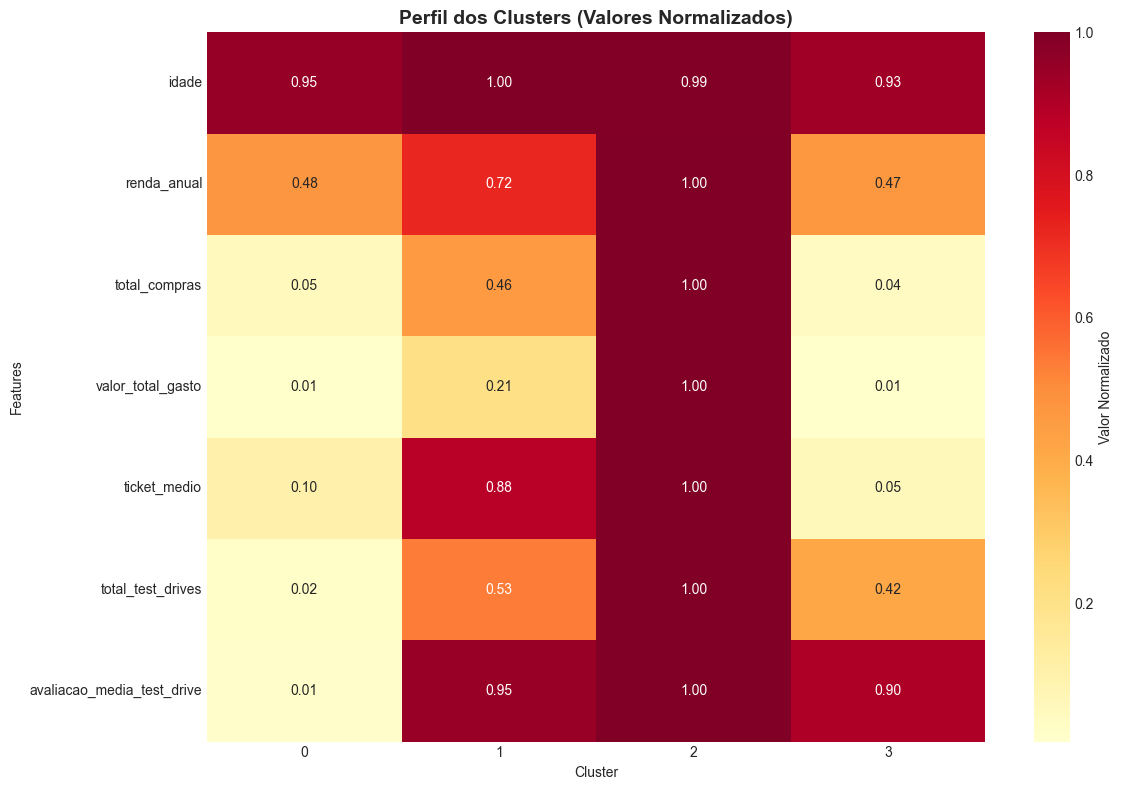

In [16]:
# Visualização do perfil dos clusters
cluster_profiles_normalized = cluster_profiles.div(cluster_profiles.max())

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profiles_normalized.T, annot=True, fmt='.2f', 
           cmap='YlOrRd', cbar_kws={'label': 'Valor Normalizado'})
plt.title('Perfil dos Clusters (Valores Normalizados)', fontsize=14, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## 8. Visualização dos Clusters (PCA)

In [17]:
# Reduzir dimensionalidade para visualização
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"📊 Variância explicada: {pca.explained_variance_ratio_.sum():.2%}")
print(f"   PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"   PC2: {pca.explained_variance_ratio_[1]:.2%}")

📊 Variância explicada: 64.96%
   PC1: 49.28%
   PC2: 15.68%


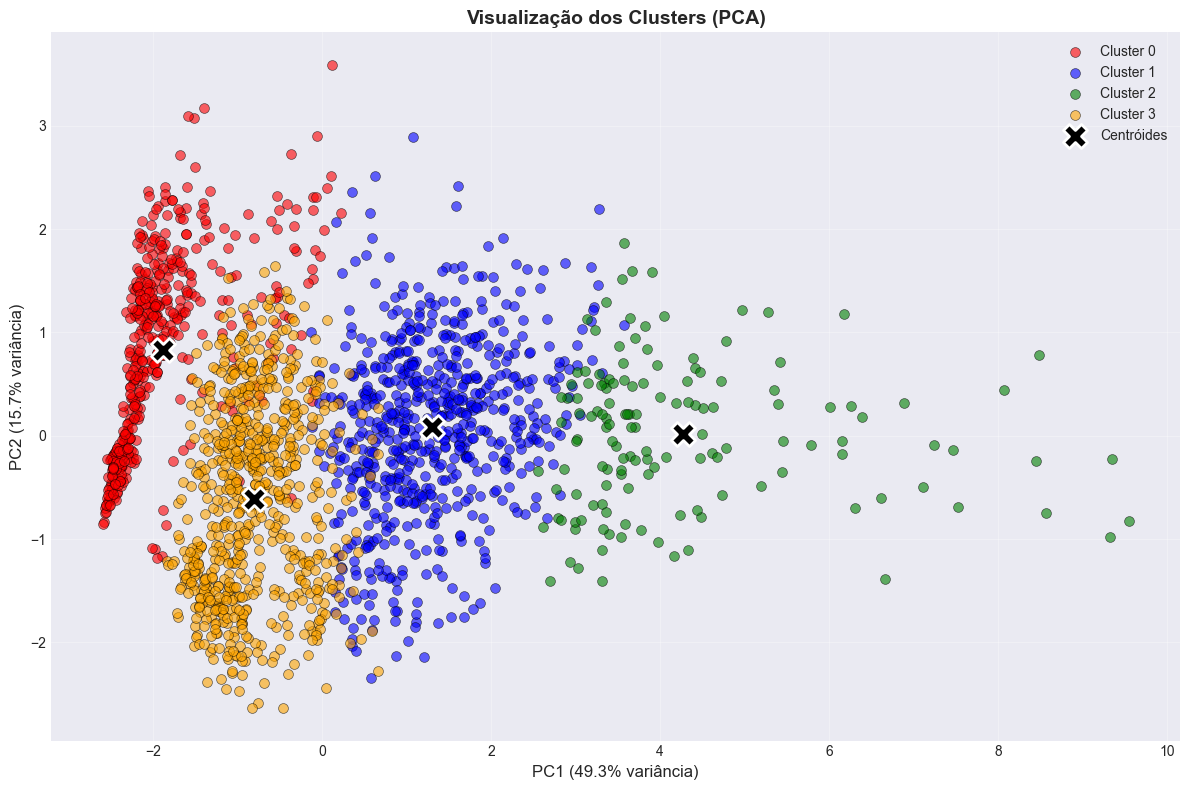

In [18]:
# Visualizar clusters em 2D
plt.figure(figsize=(12, 8))

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

for cluster_id in range(K_FINAL):
    mask = df['cluster'] == cluster_id
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=colors[cluster_id], label=f'Cluster {cluster_id}',
               alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Centróides
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
           c='black', marker='X', s=300, edgecolors='white', linewidth=2,
           label='Centróides')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variância)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variância)', fontsize=12)
plt.title('Visualização dos Clusters (PCA)', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Nomear e Interpretar os Clusters (Personas)

In [19]:
# Criar nomes para os clusters baseado no perfil
# AJUSTE CONFORME SEU RESULTADO!

cluster_names = {
    0: "💎 VIP Premium",
    1: "🌟 Alto Valor",
    2: "📈 Em Crescimento",
    3: "🆕 Novos/Inativos"
}

# Se tiver mais/menos clusters, ajuste acima

df['cluster_nome'] = df['cluster'].map(cluster_names)

print("🏷️ Clusters nomeados:")
print(df['cluster_nome'].value_counts())

🏷️ Clusters nomeados:
cluster_nome
🆕 Novos/Inativos    720
🌟 Alto Valor        653
💎 VIP Premium       463
📈 Em Crescimento    141
Name: count, dtype: int64


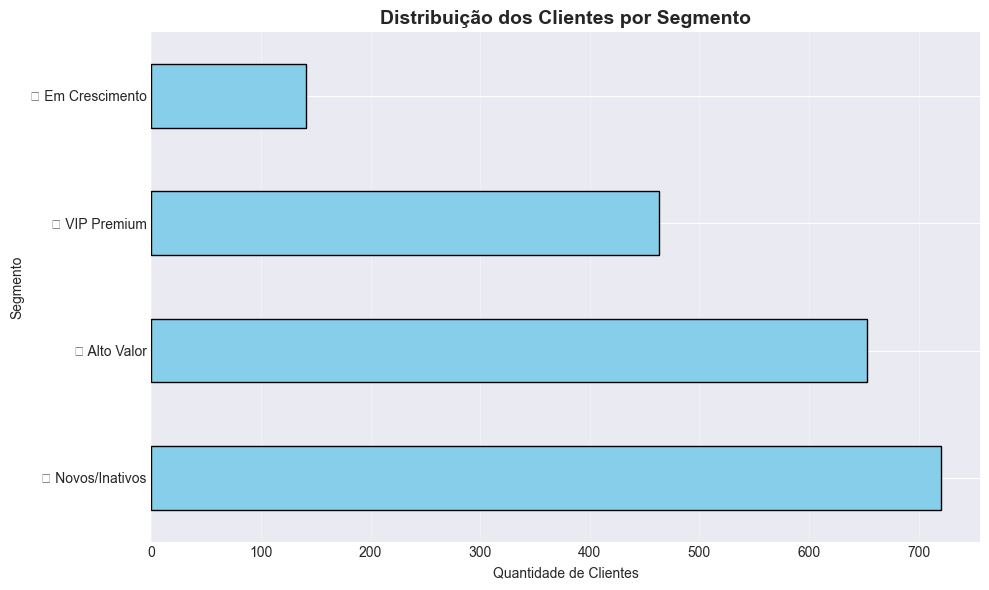

In [20]:
# Visualizar distribuição com nomes
plt.figure(figsize=(10, 6))
df['cluster_nome'].value_counts().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Distribuição dos Clientes por Segmento', fontsize=14, fontweight='bold')
plt.xlabel('Quantidade de Clientes')
plt.ylabel('Segmento')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 10. Estratégias de Marketing por Cluster

In [21]:
print("="*80)
print("🎯 ESTRATÉGIAS RECOMENDADAS POR SEGMENTO")
print("="*80)

estrategias = {
    0: """
    💎 VIP PREMIUM:
    • Atendimento exclusivo e personalizado
    • Eventos VIP e lançamentos exclusivos
    • Programa de fidelidade premium
    • Ofertas de modelos limitados e edições especiais
    • Cross-sell de acessórios premium
    """,
    
    1: """
    🌟 ALTO VALOR:
    • Programa de indicação com recompensas
    • Upgrade para próximo nível (VIP)
    • Descontos em serviços pós-venda
    • Convites para test drives de novos modelos
    • Comunicação regular de novidades
    """,
    
    2: """
    📈 EM CRESCIMENTO:
    • Financiamento facilitado
    • Promoções e descontos estratégicos
    • Programa de trade-in
    • Acompanhamento pós-venda próximo
    • Educação sobre modelos e categorias
    """,
    
    3: """
    🆕 NOVOS/INATIVOS:
    • Campanhas de reativação
    • Ofertas de primeira compra
    • Test drives gratuitos
    • Conteúdo educativo sobre carros esportivos
    • Promoções agressivas para engajamento
    """
}

for cluster_id, estrategia in estrategias.items():
    if cluster_id < K_FINAL:
        print(estrategia)
        print("-" * 80)

🎯 ESTRATÉGIAS RECOMENDADAS POR SEGMENTO

    💎 VIP PREMIUM:
    • Atendimento exclusivo e personalizado
    • Eventos VIP e lançamentos exclusivos
    • Programa de fidelidade premium
    • Ofertas de modelos limitados e edições especiais
    • Cross-sell de acessórios premium
    
--------------------------------------------------------------------------------

    🌟 ALTO VALOR:
    • Programa de indicação com recompensas
    • Upgrade para próximo nível (VIP)
    • Descontos em serviços pós-venda
    • Convites para test drives de novos modelos
    • Comunicação regular de novidades
    
--------------------------------------------------------------------------------

    📈 EM CRESCIMENTO:
    • Financiamento facilitado
    • Promoções e descontos estratégicos
    • Programa de trade-in
    • Acompanhamento pós-venda próximo
    • Educação sobre modelos e categorias
    
--------------------------------------------------------------------------------

    🆕 NOVOS/INATIVOS:
    • Camp

## 11. Exportar Resultados

In [24]:
# Salvar clientes com seus clusters
df_export = df[['cliente_id', 'nome', 'idade', 'renda_anual', 'total_compras', 
               'valor_total_gasto', 'cluster', 'cluster_nome']]

df_export.to_csv('../Dados/clientes_segmentados.csv', index=False)
print("✅ Dados exportados: Dados/clientes_segmentados.csv")

# Salvar modelo
import joblib
joblib.dump(kmeans_final, '../Modelos/kmeans_segmentacao.pkl')
joblib.dump(scaler, '../Modelos/scaler_segmentacao.pkl')
print("✅ Modelos salvos em: Modelos/")

✅ Dados exportados: Dados/clientes_segmentados.csv
✅ Modelos salvos em: Modelos/


## 12. Resumo Final

In [25]:
print("="*80)
print("📊 RESUMO DA SEGMENTAÇÃO")
print("="*80)
print(f"\n🎯 Número de clusters: {K_FINAL}")
print(f"📊 Silhouette Score: {silhouette:.3f}")
print(f"📊 Total de clientes: {len(df):,}")
print(f"\n👥 Distribuição:")
for cluster_id in range(K_FINAL):
    count = (df['cluster'] == cluster_id).sum()
    pct = count / len(df) * 100
    nome = cluster_names.get(cluster_id, f"Cluster {cluster_id}")
    print(f"   {nome}: {count:,} clientes ({pct:.1f}%)")

print(f"\n✅ Segmentação concluída com sucesso!")
print("="*80)

📊 RESUMO DA SEGMENTAÇÃO

🎯 Número de clusters: 4
📊 Silhouette Score: 0.285
📊 Total de clientes: 1,977

👥 Distribuição:
   💎 VIP Premium: 463 clientes (23.4%)
   🌟 Alto Valor: 653 clientes (33.0%)
   📈 Em Crescimento: 141 clientes (7.1%)
   🆕 Novos/Inativos: 720 clientes (36.4%)

✅ Segmentação concluída com sucesso!


---
## 🎯 Próximos Passos

1. **Aplicar estratégias diferenciadas** por segmento
2. **Monitorar migração** de clientes entre clusters
3. **Criar campanhas personalizadas** para cada grupo
4. **Prever valor futuro** de cada segmento (próximo notebook)
5. **Dashboard** com visualização dos segmentos

---